When will I win the Great Bear Run?
-----------------------------------------

This notebook presents an application of Bayesian inference to predicting the outcome of a road race.

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

import thinkbayes2
import thinkplot

import numpy as np
from scipy import stats

%matplotlib inline

Almost every year since 2008 I have participated in the Great Bear Run, a 5K road race in Needham MA.  I usually finish in the top 20 or so, and in my age group I have come in 4th, 6th, 4th, 3rd, 2nd, 4th and 4th.  In 2015 I didn't run because of a scheduling conflict, but based on the results I estimate that I would have come 4th again.

Here are the people who beat me each year.

In [2]:
data = {
    2008: ['Gardiner', 'McNatt', 'Terry'],
    2009: ['McNatt', 'Ryan', 'Partridge', 'Turner', 'Demers'],
    2010: ['Gardiner', 'Barrett', 'Partridge'],
    2011: ['Barrett', 'Partridge'],
    2012: ['Sager'],
    2013: ['Hammer', 'Wang', 'Hahn'],
    2014: ['Partridge', 'Hughes', 'Smith'],
    2015: ['Barrett', 'Sagar', 'Fernandez'],
}

So naturally I wonder if I will ever win my age group.  I'll try out two different models and see how it goes.

First, a quick function to compute binomial distributions:

In [3]:
def MakeBinomialPmf(n, p):
    ks = range(n+1)
    ps = stats.binom.pmf(ks, n, p)
    pmf = thinkbayes2.Pmf(dict(zip(ks, ps)))
    pmf.Normalize()
    return pmf

###The binomial model

The first model is based on the assumption that there is some population of runners who are faster than me, and who might show up for the Great Bear Run in any given year.  The parameters of the model are the number of runners, $n$, and their probability of showing up, $p$.

The following class uses this model to estimate the parameters from the data.  It extends `thinkbayes.Suite`, which provides a simple framework for Bayesian inference.

The `Likelihood` method computes the likelihood of the data for hypothetical values of $n$ and $p$.  For each year, it computes the number of runners who beat me, $k$, and returns the probability of $k$ given $n$ and $p$.

I explain `Predict` below.

In [4]:
class Bear1(thinkbayes2.Suite, thinkbayes2.Joint):
    def Likelihood(self, data, hypo):
        n, p = hypo
        like = 1
        for year, sobs in data.items():
            k = len(sobs)
            if k > n:
                return 0
            like *= stats.binom.pmf(k, n, p)
        return like
    
    def Predict(self):
        metapmf = thinkbayes2.Pmf()
        for (n, p), prob in bear.Items():
            pmf = MakeBinomialPmf(n, p)
            metapmf[pmf] = prob
        mix = thinkbayes2.MakeMixture(metapmf)
        return mix

The prior distribution for $n$ is uniform from 16 to 70 (16 is the number of unique runners who have beat me; 70 is an arbitrary upper bound).

The prior distribution for $p$ is uniform from 0 to 1.

In [5]:
hypos = [(n, p) for n in range(16, 70) for p in np.linspace(0, 1, 101)]
bear = Bear1(hypos)

The `Update` function is provided by `thinkbayes.Suite`; it computes the likelihood of the data for each hypothesis, multiplies by the prior probabilities, and renormalizes.

The return value is the normalizing constant, which is total probability of the data under the prior (but otherwise not particularly meaningful).

In [6]:
bear.Update(data)

9.7429617466130483e-08

From the joint posterior distribution we can extract the marginal distributions of $n$ and $p$.

0.048848085866427957

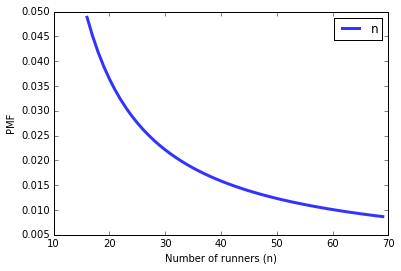

In [28]:
pmf_n = bear.Marginal(0)
thinkplot.Pdf(pmf_n, label='n')
thinkplot.Config(xlabel='Number of runners (n)', ylabel='PMF')
pmf_n[16]

0.059999999999999998

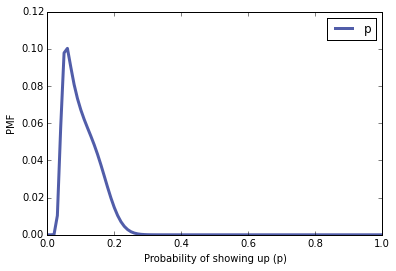

In [30]:
pmf_p = bear.Marginal(1)
thinkplot.Pdf(pmf_p, label='p')
thinkplot.Config(xlabel='Probability of showing up (p)', ylabel='PMF')
pmf_p.MaximumLikelihood()

In [9]:
stats.binom.pmf(0, 16, 0.06)

0.37157429083410093

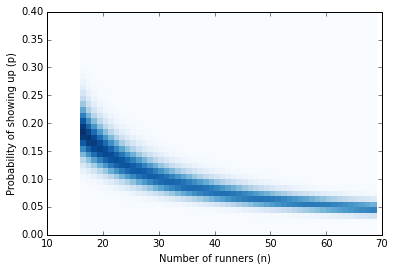

In [32]:
thinkplot.Contour(bear, pcolor=True, contour=False)
thinkplot.Config(xlabel='Number of runners (n)',
                 ylabel='Probability of showing up (p)',
                 ylim=[0, 0.4])

0.052046954456205559

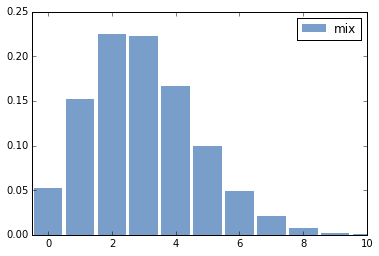

In [11]:
predict = bear.Predict()
thinkplot.Hist(predict)
thinkplot.Config(xlim=[-0.5, 10])
predict[0]

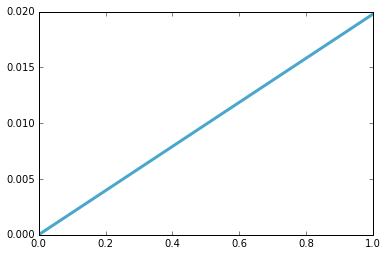

In [12]:
ss = thinkbayes2.Beta(2, 1)
thinkplot.Pdf(ss.MakePmf())

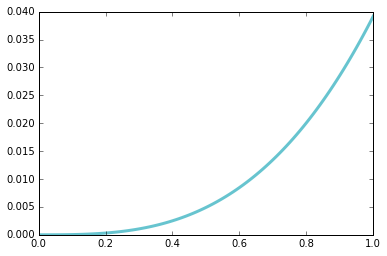

In [13]:
os = thinkbayes2.Beta(4, 1)
thinkplot.Pdf(os.MakePmf())

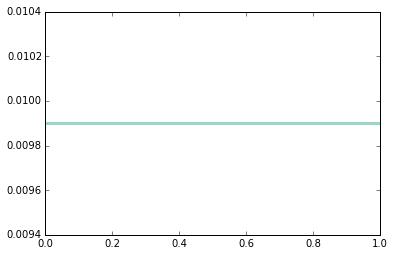

In [14]:
bs = thinkbayes2.Beta(1, 1)
thinkplot.Pdf(bs.MakePmf())

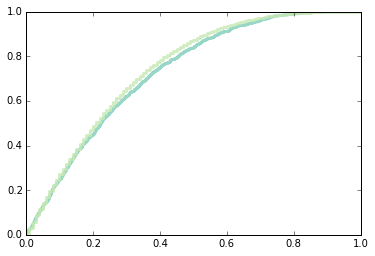

In [27]:
n = 1000
sample = ss.Sample(n) * os.Sample(n) * bs.Sample(n)
cdf = thinkbayes2.Cdf(sample)
thinkplot.Cdf(cdf)

prior = thinkbayes2.Beta(1, 3)
thinkplot.Cdf(prior.MakeCdf());

In [16]:
from itertools import chain
from collections import Counter

counter = Counter(chain(*data.values()))
len(counter), counter

(16,
 Counter({'Partridge': 4, 'Barrett': 3, 'Gardiner': 2, 'McNatt': 2, 'Demers': 1, 'Hughes': 1, 'Hahn': 1, 'Wang': 1, 'Smith': 1, 'Ryan': 1, 'Sager': 1, 'Sagar': 1, 'Terry': 1, 'Turner': 1, 'Hammer': 1, 'Fernandez': 1}))

In [17]:
def MakeBeta(count, num_races, precount=3):
    beta = thinkbayes2.Beta(1, precount)
    beta.Update((count, num_races-count))
    return beta

In [18]:
num_races = len(data)
betas = [MakeBeta(count, num_races) 
         for count in counter.values()]

In [19]:
[beta.Mean() for beta in betas]

[0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.25,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.25,
 0.16666666666666666,
 0.16666666666666666,
 0.4166666666666667,
 0.16666666666666666,
 0.16666666666666666,
 0.16666666666666666,
 0.3333333333333333]

In [20]:
class Bear2(thinkbayes2.Suite, thinkbayes2.Joint):

    def ComputePmfs(self, data):
        num_races = len(data)
        counter = Counter(chain(*data.values()))
        betas = [MakeBeta(count, num_races) 
                 for count in counter.values()]
        
        self.pmfs = dict()
        low = len(betas)
        high = max(self.Values())
        for n in range(low, high+1):
            self.pmfs[n] = self.ComputePmf(betas, n, num_races)
    
    def ComputePmf(self, betas, n, num_races):
        no_show = thinkbayes2.Beta(1, num_races+1)
        all_betas = betas + [no_show] * (n - len(betas))
        
        ks = []
        for i in range(1000):
            ps = [beta.Random() for beta in all_betas]
            xs = np.random.random(len(ps))
            k = sum(xs < ps)
            ks.append(k)
            
        return thinkbayes2.Pmf(ks)
    
    def Likelihood(self, data, hypo):
        n = hypo
        k = data
        return self.pmfs[n][k]
    
    def Predict(self):
        metapmf = thinkbayes2.Pmf()
        for n, prob in self.Items():
            pmf = bear2.pmfs[n]
            metapmf[pmf] = prob
        mix = thinkbayes2.MakeMixture(metapmf)
        return mix

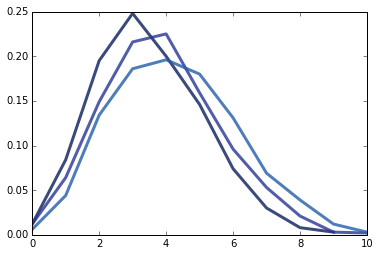

In [21]:
bear2 = Bear2()
pmf = bear2.ComputePmf(betas, 18, num_races)
pmf2 = bear2.ComputePmf(betas, 22, num_races)
pmf3 = bear2.ComputePmf(betas, 26, num_races)
thinkplot.Pdfs([pmf, pmf2, pmf3])

In [22]:
low = 16
high = 35
bear2 = Bear2(range(low, high))
bear2.ComputePmfs(data)

In [23]:
for year, sobs in data.items():
    k = len(sobs)
    bear2.Update(k)

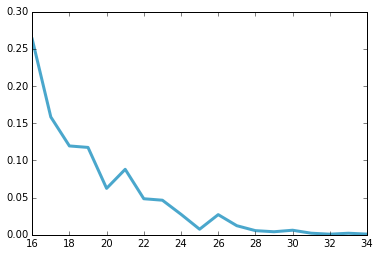

In [24]:
thinkplot.Pdf(bear2)

In [25]:
predict = bear2.Predict()

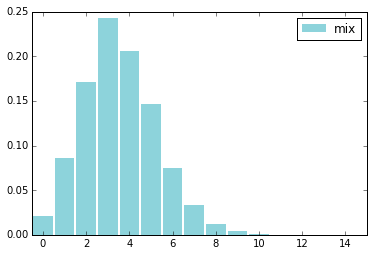

In [26]:
thinkplot.Hist(predict)
thinkplot.Config(xlim=[-0.5, 15])